# Compare double wake results in all cases

Expand comparison to all single wakes occuring in aligned simulations across 8-9 m/s

In [146]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.optimize import minimize

## Load FLORIS models and SOWFA DATA

In [147]:
df = pickle.load( open( "sowfa_04.p", "rb" ) )
# fi_dict = pickle.load( open( "floris_models_2.p", "rb" ) ) # Before retuning TI
fi_dict = pickle.load( open( "floris_models_3.p", "rb" ) ) # After retuning TI
fi_dict

{'g': (<floris.tools.floris_interface.FlorisInterface at 0x11dbff050>,
  'b',
  's',
  'gauss'),
 'gt': (<floris.tools.floris_interface.FlorisInterface at 0x11d5db490>,
  'r',
  'd',
  'gauss_tune'),
 'gch': (<floris.tools.floris_interface.FlorisInterface at 0x11d5daad0>,
  'g',
  'o',
  'gch_paper'),
 'leg': (<floris.tools.floris_interface.FlorisInterface at 0x11d5cd8d0>,
  'gray',
  '^',
  'legacy')}

In [148]:
# Make a color dict
color_dict = dict()
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    color_dict[floris_label] = floris_color

In [149]:
# # Make ka and kb in deflection model match

# (fi, floris_color, floris_marker, floris_label) = fi_dict['gt']

# model_params = fi.get_model_parameters()


# model_params['Wake Deflection Parameters']['ka'] = .22
# model_params['Wake Deflection Parameters']['kb'] = .002



# fi.set_model_parameters(model_params,verbose=False)

# fi_dict['gt'] = (fi, floris_color, floris_marker, floris_label)


In [193]:
# # Make ka and kb in deflection model match

# (fi, floris_color, floris_marker, floris_label) = fi_dict['gt']

# model_params = fi.get_model_parameters()


# model_params['Wake Deflection Parameters']['ka'] = .22
# model_params['Wake Deflection Parameters']['kb'] = .002
# model_params['Wake Velocity Parameters']['yaw_recovery_alpha'] = .003
# model_params['Wake Velocity Parameters']['eps_gain'] = .1
# model_params['Wake Deflection Parameters']['eps_gain'] = .1



# fi.set_model_parameters(model_params,verbose=False)

# fi_dict['gt'] = (fi, floris_color, floris_marker, floris_label)


In [221]:
# Adjust tune gauss to results below

(fi, floris_color, floris_marker, floris_label) = fi_dict['gt']

model_params = fi.get_model_parameters()

model_params['Wake Deflection Parameters']['ka'] = .38
model_params['Wake Deflection Parameters']['kb'] = .004
model_params['Wake Velocity Parameters']['yaw_recovery_alpha'] = .055
model_params['Wake Velocity Parameters']['eps_gain'] = .55
model_params['Wake Deflection Parameters']['eps_gain'] = .55



fi.set_model_parameters(model_params,verbose=False)

fi_dict['gt'] = (fi, floris_color, floris_marker, floris_label)

## Limit DF to tuning cases

In [222]:
print(df.shape)

(404, 22)


In [223]:
# Limit to aligned only
# df = df[df.yaw.apply(lambda x: np.max(np.abs(x)))==0.0]

In [224]:
# Limit to < 6 turbines
df = df[df.num_turbines < 6]

In [225]:
# Limit to 8 m/s (or not, comment out)
df = df[df.sowfa_U0<9]
df.shape

(404, 22)

# Calculate the power in each case

Make sure now to include yaw angles

In [226]:
# Get the single wake results in all simulations
results_df = pd.DataFrame()

for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]

    # Set up FLORIS to match
    # Determine free-stream wind speed column
    freestream_name = 'freestream_' + floris_label
    

    for i, row in df.iterrows():


        # Match the layout
        if (floris_label == 'gch_paper') or (floris_label == 'legacy'):
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                               wind_speed=[row[freestream_name]],
                              turbulence_intensity=[row.floris_TI])
        else:
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                       wind_speed=[row[freestream_name]],
                                      turbulence_intensity=[row.freestream_ti])

        
        fi.calculate_wake(yaw_angles=row.yaw)

        floris_power = np.mean(np.array(fi.get_turbine_power())/1000.)

        sowfa_power = np.mean(row.power)



        result_dict = {'sowfa_power':[sowfa_power],
                       'floris_power':[floris_power],
                       'floris_label':[floris_label],
                       'sowfa_U0':[row.sowfa_U0],
                       'sowfa_TI':[row.sowfa_TI],
                       'yaw':[row.yaw],
                       'layout_x':[row.layout_x],
                       'layout_y':[row.layout_y],
                       'num_turbines':row.num_turbines,
                       'd_spacing':row.d_spacing
                      }

        results_df = results_df.append(pd.DataFrame(result_dict))

results_df.head()

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing
0,1571.35,1541.475533,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,1504.90,1543.830974,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,1327.45,1432.336979,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,1303.25,1326.137115,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0
0,1345.35,1354.297744,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0


In [227]:
# Assign a baseline power to each row
baseline = []
baseline_sowfa = []
for i, row in results_df.iterrows():
    yaw = row.yaw
    
    # Find the row that is this rows baseline
    df_sub = results_df[(results_df.layout_x == row.layout_x) & 
                        (results_df.layout_y == row.layout_y) & 
                        (results_df.sowfa_U0 == row.sowfa_U0) & 
                        (results_df.sowfa_TI == row.sowfa_TI) & 
                        (results_df.yaw.apply(lambda x: np.max(np.abs(x)))==0.0) &
                        (results_df.floris_label == row.floris_label)]
    if df_sub.shape[0] == 0:
        baseline.append(np.nan)
        baseline_sowfa.append(np.nan)
    else:
        baseline.append(df_sub.floris_power.values[0])
        baseline_sowfa.append(df_sub.sowfa_power.values[0])

results_df['baseline_floris'] = baseline
results_df['baseline_sowfa'] = baseline_sowfa
results_df.head()

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing,baseline_floris,baseline_sowfa
0,1571.35,1541.475533,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1543.830974,1504.90
0,1504.90,1543.830974,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1543.830974,1504.90
0,1327.45,1432.336979,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1543.830974,1504.90
0,1303.25,1326.137115,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1354.297744,1345.35
0,1345.35,1354.297744,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1354.297744,1345.35


In [228]:
# Remove missing values
# plt.plot(results_df.baseline_floris.isnull())
print(results_df.shape)
results_df = results_df[~results_df.baseline_floris.isnull()]
print(results_df.shape)

(1616, 12)
(1616, 12)


In [229]:
# drop the baseline cases
print(results_df.shape)
results_df = results_df[results_df.yaw.apply(lambda x: np.max(np.abs(x)))!=0.0]
print(results_df.shape)

(1616, 12)
(1380, 12)


In [230]:
# compute the gains
results_df['sowfa_gain'] = results_df.sowfa_power - results_df.baseline_sowfa
results_df['sowfa_gain_nom'] = 100. * (results_df.sowfa_power - results_df.baseline_sowfa) / results_df.baseline_sowfa
results_df['floris_gain'] = results_df.floris_power - results_df.baseline_floris
results_df['floris_gain_nom'] = 100. * (results_df.floris_power - results_df.baseline_floris) / results_df.baseline_floris

In [231]:
results_df.head()

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing,baseline_floris,baseline_sowfa,sowfa_gain,sowfa_gain_nom,floris_gain,floris_gain_nom
0,1571.35,1541.475533,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1543.830974,1504.90,66.45,4.415576,-2.355441,-0.152571
0,1327.45,1432.336979,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1543.830974,1504.90,-177.45,-11.791481,-111.493995,-7.221904
0,1303.25,1326.137115,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1354.297744,1345.35,-42.10,-3.129297,-28.160630,-2.079353
0,1363.90,1398.096606,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1354.297744,1345.35,18.55,1.378823,43.798862,3.234064
0,1360.70,1307.146134,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1063.0)",2,5.0,1542.925884,1577.00,-216.30,-13.715916,-235.779751,-15.281340


In [232]:
# Compare the gains at the start
use_nominal = False

if use_nominal:
    sowfa_signal = 'sowfa_gain_nom'
    floris_signal = 'floris_gain_nom'
else:
    sowfa_signal = 'sowfa_gain'
    floris_signal = 'floris_gain'    
g = sns.FacetGrid(results_df, row='num_turbines',col='sowfa_TI',hue='floris_label',palette=color_dict,aspect=2)
g.map(plt.scatter,sowfa_signal,floris_signal)
for ax in g.axes.flatten():
    ax.plot([results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],
            [results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],'k--')
    ax.axhline(0,color='gray')
    ax.axvline(0,color='gray')
g.add_legend()

In [233]:
# Compare in terms of error
results_df['gain_error'] = results_df.floris_gain - results_df.sowfa_gain

g = sns.FacetGrid(results_df, row='num_turbines',col='sowfa_TI',hue='floris_label',palette=color_dict,aspect=2)
g.map(plt.scatter,sowfa_signal,'gain_error',s=8)
for ax in g.axes.flatten():
#     ax.plot([results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],
#             [results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],'k--')
    ax.axhline(0,color='gray')
    ax.axvline(0,color='gray')
g.add_legend()

In [234]:
## Look at RMS error
# Check for an overall bias and rms
results_df[['gain_error','floris_label']].groupby('floris_label').agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])



gain_error                     
                   mean    median   <lambda>
floris_label                                
gauss         -3.591674 -3.262829  45.937360
gauss_tune     6.780072  6.656232  30.389259
gch_paper      1.568121  2.197402  40.345250
legacy       -18.865766 -4.766677  65.480220

In [237]:
results_df[['gain_error','floris_label','num_turbines']].groupby(['floris_label','num_turbines']).agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])


gain_error                        
                                 mean      median    <lambda>
floris_label num_turbines                                    
gauss        2              -0.439724    3.692192   54.635888
             3               1.714640   -3.064609   40.169073
             4              14.882815   13.230184   16.698243
             5             -69.456309  -73.203078   79.903774
gauss_tune   2              -0.382780    3.235975   39.020963
             3              10.706271    8.429084   29.478216
             4               5.224103    4.922966    7.417226
             5             -15.140512  -14.768206   32.018110
gch_paper    2              -7.237863    2.108778   49.126494
             3               2.524355   -1.457123   41.206730
             4              15.327267   13.416699   16.455074
             5              -2.016169   -3.012854   25.513016
legacy       2              -1.902083   -1.795491   35.775592
             3              -9.735190   -2.692648   53.939961
             4               8.014075    5.670759   11.376406
             5            -148.063411 -153.155439  156.880205

In [ ]:
# Can now save if on the loop back

In [238]:
fi_dict

{'g': (<floris.tools.floris_interface.FlorisInterface at 0x11dbff050>,
  'b',
  's',
  'gauss'),
 'gt': (<floris.tools.floris_interface.FlorisInterface at 0x11d5db490>,
  'r',
  'd',
  'gauss_tune'),
 'gch': (<floris.tools.floris_interface.FlorisInterface at 0x11d5daad0>,
  'g',
  'o',
  'gch_paper'),
 'leg': (<floris.tools.floris_interface.FlorisInterface at 0x11d5cd8d0>,
  'gray',
  '^',
  'legacy')}

In [239]:
pickle.dump( fi_dict, open( "floris_models_4.p", "wb" ) )

## Tune GCH parameters

In [165]:
(fi, floris_color, floris_marker, floris_label) = fi_dict['gt']

model_params = fi.get_model_parameters()
model_params

{'Wake Velocity Parameters': {'alpha': 0.58,
  'beta': 0.077,
  'calculate_VW_velocities': True,
  'eps_gain': 0.3,
  'ka': 0.22077999999999998,
  'kb': 0.002,
  'use_yaw_added_recovery': True,
  'yaw_recovery_alpha': 0.03},
 'Wake Deflection Parameters': {'ad': 0.0,
  'alpha': 0.58,
  'bd': 0.0,
  'beta': 0.077,
  'eps_gain': 0.3,
  'ka': 0.22,
  'kb': 0.002,
  'use_secondary_steering': True},
 'Wake Turbulence Parameters': {'ti_ai': 0.44499519200000004,
  'ti_constant': 0.365,
  'ti_downstream': -0.35443974775000003,
  'ti_initial': 0.05}}

In [97]:
eps_array = 0.3 * np.logspace(-1,1,10)
alpha_array = 0.03 * np.logspace(-1,1,10)

num_case = len(eps_array) * len(alpha_array)
alpha_array

array([0.003     , 0.0050043 , 0.00834768, 0.01392477, 0.02322791,
       0.03874649, 0.06463304, 0.10781441, 0.17984528, 0.3       ])

In [167]:
eps_array = np.array([.1,.2,.3,.4,.5])
alpha_array = eps_array / 10.
num_case = len(eps_array) * len(alpha_array)

In [183]:
eps_array = np.array([.03,.06, .09,.12,.15,.18,.21])
alpha_array = np.array([.005, .01,.015, .02, .025, .03, .035, .04, .045,.05,.055])
num_case = len(eps_array) * len(alpha_array)

In [117]:
eps_array = np.array([.45,.55,.65])
alpha_array = eps_array / 10.
num_case = len(eps_array) * len(alpha_array)

In [184]:
# Get the single wake results in all simulations
results_tuning = pd.DataFrame()

count = 0
for alpha in alpha_array:
    for eps in eps_array:
        
        if count % 5 == 0:
            print('Case %03d of %d' % (count,num_case))
        count = count + 1

        # Set up FLORIS to match
        # Determine free-stream wind speed column
        freestream_name = 'freestream_' + floris_label

        
        model_params['Wake Velocity Parameters']['yaw_recovery_alpha'] = alpha
        model_params['Wake Velocity Parameters']['eps_gain'] = eps
        model_params['Wake Deflection Parameters']['eps_gain'] = eps

    

        fi.set_model_parameters(model_params,verbose=False)
        for i, row in df.iterrows():


            # Match the layout
            if (floris_label == 'gch_paper') or (floris_label == 'legacy'):
                fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                   wind_speed=[row[freestream_name]],
                                  turbulence_intensity=[row.floris_TI])
            else:
                fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                           wind_speed=[row[freestream_name]],
                                          turbulence_intensity=[row.freestream_ti])


            fi.calculate_wake(yaw_angles=row.yaw)

            floris_power = np.mean(np.array(fi.get_turbine_power())/1000.)

            sowfa_power = np.mean(row.power)

            result_dict = {'sowfa_power':[sowfa_power],
                           'floris_power':[floris_power],
                           'floris_label':[floris_label],
                           'alpha':[alpha],
                           'eps_gain':[eps],
                           'sowfa_U0':[row.sowfa_U0],
                           'sowfa_TI':[row.sowfa_TI],
                           'yaw':[row.yaw],
                           'layout_x':[row.layout_x],
                           'layout_y':[row.layout_y],
                           'num_turbines':row.num_turbines,
                           'd_spacing':row.d_spacing
                          }

            results_tuning = results_tuning.append(pd.DataFrame(result_dict))

results_tuning.head()

Case 000 of 77
Case 005 of 77
Case 010 of 77
Case 015 of 77
Case 020 of 77
Case 025 of 77
Case 030 of 77
Case 035 of 77
Case 040 of 77
Case 045 of 77
Case 050 of 77
Case 055 of 77
Case 060 of 77
Case 065 of 77
Case 070 of 77
Case 075 of 77


,sowfa_power,floris_power,floris_label,alpha,eps_gain,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing
0,1571.35,1628.982382,gauss_tune,0.005,0.03,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,1504.90,1567.678681,gauss_tune,0.005,0.03,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,1327.45,1388.889432,gauss_tune,0.005,0.03,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,1303.25,1366.756565,gauss_tune,0.005,0.03,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0
0,1345.35,1358.459173,gauss_tune,0.005,0.03,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0


In [185]:
# Assign a baseline power to each row
baseline = []
baseline_sowfa = []
for i, row in results_tuning.iterrows():
    yaw = row.yaw
    
    # Find the row that is this rows baseline
    df_sub = results_tuning[(results_tuning.layout_x == row.layout_x) & 
                        (results_tuning.layout_y == row.layout_y) & 
                        (results_tuning.sowfa_U0 == row.sowfa_U0) & 
                        (results_tuning.sowfa_TI == row.sowfa_TI) & 
                        (results_tuning.yaw.apply(lambda x: np.max(np.abs(x)))==0.0) &
                        (results_tuning.alpha == row.alpha) & 
                        (results_tuning.eps_gain == row.eps_gain)  ]
    if df_sub.shape[0] == 0:
        baseline.append(np.nan)
        baseline_sowfa.append(np.nan)
    else:
        baseline.append(df_sub.floris_power.values[0])
        baseline_sowfa.append(df_sub.sowfa_power.values[0])

results_tuning['baseline_floris'] = baseline
results_tuning['baseline_sowfa'] = baseline_sowfa
results_tuning.head()

,sowfa_power,floris_power,floris_label,alpha,eps_gain,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing,baseline_floris,baseline_sowfa
0,1571.35,1628.982382,gauss_tune,0.005,0.03,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1567.678681,1504.90
0,1504.90,1567.678681,gauss_tune,0.005,0.03,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1567.678681,1504.90
0,1327.45,1388.889432,gauss_tune,0.005,0.03,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1567.678681,1504.90
0,1303.25,1366.756565,gauss_tune,0.005,0.03,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1358.459173,1345.35
0,1345.35,1358.459173,gauss_tune,0.005,0.03,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1358.459173,1345.35


In [186]:
# drop the baseline cases
print(results_tuning.shape)
results_tuning = results_tuning[results_tuning.yaw.apply(lambda x: np.max(np.abs(x)))!=0.0]
print(results_tuning.shape)

(31108, 14)
(26565, 14)


In [187]:
# compute the gains
results_tuning['sowfa_gain'] = results_tuning.sowfa_power - results_tuning.baseline_sowfa
results_tuning['sowfa_gain_nom'] = 100. * (results_tuning.sowfa_power - results_tuning.baseline_sowfa) / results_tuning.baseline_sowfa
results_tuning['floris_gain'] = results_tuning.floris_power - results_tuning.baseline_floris
results_tuning['floris_gain_nom'] = 100. * (results_tuning.floris_power - results_tuning.baseline_floris) / results_tuning.baseline_floris
results_tuning['gain_error'] = results_tuning.floris_gain - results_tuning.sowfa_gain




In [188]:
results_tuning.head()

,sowfa_power,floris_power,floris_label,alpha,eps_gain,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing,baseline_floris,baseline_sowfa,sowfa_gain,sowfa_gain_nom,floris_gain,floris_gain_nom,gain_error
0,1571.35,1628.982382,gauss_tune,0.005,0.03,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1567.678681,1504.90,66.45,4.415576,61.303701,3.910476,-5.146299
0,1327.45,1388.889432,gauss_tune,0.005,0.03,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1567.678681,1504.90,-177.45,-11.791481,-178.789249,-11.404713,-1.339249
0,1303.25,1366.756565,gauss_tune,0.005,0.03,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1358.459173,1345.35,-42.10,-3.129297,8.297392,0.610794,50.397392
0,1363.90,1372.150189,gauss_tune,0.005,0.03,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1358.459173,1345.35,18.55,1.378823,13.691016,1.007834,-4.858984
0,1360.70,1380.711583,gauss_tune,0.005,0.03,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1063.0)",2,5.0,1566.808507,1577.00,-216.30,-13.715916,-186.096924,-11.877452,30.203076


In [189]:
# Compute RMS error
rms_df = results_tuning[['gain_error','alpha','eps_gain']].groupby(['alpha','eps_gain']).agg([lambda x: np.sqrt(np.sum(x**2)/len(x))])# .reset_index()

rms_df = rms_df.unstack()
rms_df.columns=[c[2] for c in rms_df.columns]


rms_df

,0.03,0.06,0.09,0.12,0.15,0.18,0.21
alpha,,,,,,,
0.005,45.294634,39.374438,34.299457,33.593005,37.921993,44.180420,50.315581
0.010,45.568625,40.192546,35.168086,33.190538,35.367416,39.874805,44.835182
0.015,45.785600,40.873140,36.015591,33.330549,33.917782,36.930647,40.600866
0.020,45.961886,41.435202,36.806480,33.729871,33.207846,34.979218,37.645901
0.025,46.107657,41.908521,37.521743,34.249444,33.020157,33.799413,35.498249
0.030,46.230009,42.311389,38.153512,34.796989,33.132099,33.134799,34.116071
0.035,46.333971,42.657562,38.716770,35.362262,33.401661,32.875003,33.267563
0.040,46.423231,42.957145,39.218541,35.909074,33.772836,32.872959,32.778687
0.045,46.500552,43.220653,39.665896,36.435192,34.179564,33.026737,32.580582


In [190]:
X=rms_df.columns.values
Y=rms_df.index.values
Z=rms_df.values
x,y=np.meshgrid(X, Y)

fig, ax = plt.subplots()
ax.contourf(x, y, Z,cmap='gray')
CS = ax.contour(x, y, Z,colors='w')
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlabel('Eps')
ax.set_ylabel('Alpha')

Text(0, 0.5, 'Alpha')

In [191]:
# Compute RMS error
rms_df = results_tuning[['gain_error','alpha','eps_gain']].groupby(['alpha','eps_gain']).mean()# .reset_index()

rms_df = rms_df.unstack()
rms_df.columns=[c[1] for c in rms_df.columns]


rms_df

,0.03,0.06,0.09,0.12,0.15,0.18,0.21
alpha,,,,,,,
0.005,-3.865009,0.397977,5.775198,11.565188,16.700455,20.608204,23.553732
0.010,-4.038999,-0.250080,4.515778,9.699253,14.409406,18.183721,21.162672
0.015,-4.178167,-0.740439,3.496108,8.162677,12.452135,16.041756,18.880086
0.020,-4.291819,-1.159313,2.679143,6.890626,10.854027,14.100618,16.883279
0.025,-4.386245,-1.507196,2.001929,5.853908,9.447190,12.424350,15.033869
0.030,-4.465844,-1.800349,1.411494,4.951364,8.257537,11.063770,13.421588
0.035,-4.533754,-2.050274,0.907076,4.173669,7.226794,9.826169,12.011720
0.040,-4.592277,-2.266810,0.498861,3.504837,6.364632,8.751510,10.827418
0.045,-4.643150,-2.434539,0.121324,2.942050,5.588379,7.807579,9.764558


In [192]:
X=rms_df.columns.values
Y=rms_df.index.values
Z=rms_df.values
x,y=np.meshgrid(X, Y)

fig, ax = plt.subplots()
ax.contourf(x, y, Z,cmap='gray')
CS = ax.contour(x, y, Z,colors='w')
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlabel('Eps')
ax.set_ylabel('Alpha')

Text(0, 0.5, 'Alpha')

In [105]:
%matplotlib

Using matplotlib backend: MacOSX


In [39]:
results_tuning

,alpha,baseline_floris,baseline_sowfa,d_spacing,eps_gain,floris_gain,floris_gain_nom,floris_label,floris_power,gain_error,layout_x,layout_y,num_turbines,sowfa_TI,sowfa_U0,sowfa_gain,sowfa_gain_nom,sowfa_power,yaw
0,NaN,1543.830974,1504.900000,5.0,NaN,-2.355441,-0.152571,gauss,1541.475533,-68.805441,"(1000.0, 1630.0)","(1000.0, 937.0)",2,0.10,8.0,66.450000,4.415576,1571.350000,"[-20.0, 0.0]"
0,NaN,1543.830974,1504.900000,5.0,NaN,-111.493995,-7.221904,gauss,1432.336979,65.956005,"(1000.0, 1630.0)","(1000.0, 937.0)",2,0.10,8.0,-177.450000,-11.791481,1327.450000,"[20.0, 0.0]"
0,NaN,1354.297744,1345.350000,5.0,NaN,-28.160630,-2.079353,gauss,1326.137115,13.939370,"(1000.0, 1630.0)","(1000.0, 1000.0)",2,0.10,8.0,-42.100000,-3.129297,1303.250000,"[-20.0, 0.0]"
0,NaN,1354.297744,1345.350000,5.0,NaN,43.798862,3.234064,gauss,1398.096606,25.248862,"(1000.0, 1630.0)","(1000.0, 1000.0)",2,0.10,8.0,18.550000,1.378823,1363.900000,"[20.0, 0.0]"
0,NaN,1542.925884,1577.000000,5.0,NaN,-235.779751,-15.281340,gauss,1307.146134,-19.479751,"(1000.0, 1630.0)","(1000.0, 1063.0)",2,0.10,8.0,-216.300000,-13.715916,1360.700000,"[-20.0, 0.0]"
0,NaN,1542.925884,1577.000000,5.0,NaN,143.311722,9.288309,gauss,1686.237606,73.311722,"(1000.0, 1630.0)","(1000.0, 1063.0)",2,0.10,8.0,70.000000,4.438808,1647.000000,"[20.0, 0.0]"
0,NaN,1175.054397,1161.150000,6.0,NaN,-46.476397,-3.955255,gauss,1128.578000,-4.376397,"(1000.0, 1756.0)","(850.0, 850.0)",2,0.10,8.0,-42.100000,-3.625716,1119.050000,"[0.0, 20.0]"
0,NaN,1175.054397,1161.150000,6.0,NaN,18.474641,1.572237,gauss,1193.529038,-12.925359,"(1000.0, 1756.0)","(850.0, 850.0)",2,0.10,8.0,31.400000,2.704216,1192.550000,"[20.0, 0.0]"
0,NaN,1175.054397,1161.150000,6.0,NaN,-38.828505,-3.304401,gauss,1136.225892,4.271495,"(1000.0, 1756.0)","(850.0, 850.0)",2,0.10,8.0,-43.100000,-3.711837,1118.050000,"[20.0, 20.0]"
0,NaN,1415.742527,1395.100000,6.0,NaN,-51.453660,-3.634394,gauss,1364.288867,-7.853660,"(1000.0, 1756.0)","(1000.0, 1000.0)",2,0.10,8.0,-43.600000,-3.125224,1351.500000,"[0.0, 20.0]"


In [39]:
results_df[(results_df.layout_x == row.layout_x) & 
                        (results_df.layout_y == row.layout_y) & 
                        (results_df.sowfa_U0 == row.sowfa_U0) & 
                        (results_df.sowfa_TI == row.sowfa_TI)]

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing
0,1111.6,835.901504,gauss,8.0,0.1,"[30.0, 30.0, 26.0, 22.0, 0.0]","(1000.0, 1510.4, 2020.7, 2531.1, 3041.5)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,4.050794
0,1111.6,796.404070,gauss_tune,8.0,0.1,"[30.0, 30.0, 26.0, 22.0, 0.0]","(1000.0, 1510.4, 2020.7, 2531.1, 3041.5)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,4.050794
0,1111.6,775.133244,gch_paper,8.0,0.1,"[30.0, 30.0, 26.0, 22.0, 0.0]","(1000.0, 1510.4, 2020.7, 2531.1, 3041.5)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,4.050794
0,1111.6,777.257757,legacy,8.0,0.1,"[30.0, 30.0, 26.0, 22.0, 0.0]","(1000.0, 1510.4, 2020.7, 2531.1, 3041.5)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,4.050794


In [40]:
results_df[results_df.num_turbines==5]

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing
0,1111.60,835.901504,gauss,8.0,0.10,"[30.0, 30.0, 26.0, 22.0, 0.0]","(1000.0, 1510.4, 2020.7, 2531.1, 3041.5)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,4.050794
0,1132.04,878.864072,gauss,8.0,0.10,"[28.19999999999999, 29.80000000000001, 25.3000...","(1000.0, 1523.2, 2046.4, 2569.6, 3092.8)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,4.152381
0,1204.92,914.643311,gauss,8.0,0.10,"[30.0, 28.599999999999994, 26.099999999999994,...","(1000.0, 1663.7, 2327.4, 2991.0, 3654.7)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,5.267460
0,1154.76,965.374832,gauss,8.0,0.10,"[25.69999999999999, 28.099999999999994, 22.5, ...","(1000.0, 1672.6, 2253.5, 2818.3, 3361.6)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,5.338095
0,1092.02,1287.250206,gauss,8.0,0.10,"[0.0, 0.0, 0.0, 0.0, 0.0]","(1000.0, 1756.0, 2512.0, 3268.0, 4024.0)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,6.000000
0,1105.94,1305.445871,gauss,8.0,0.10,"[5.0, 10.0, 15.0, 20.0, 0.0]","(1000.0, 1756.0, 2512.0, 3268.0, 4024.0)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,6.000000
0,1174.36,1260.575374,gauss,8.0,0.10,"[12.899999999999977, 23.400000000000006, 19.69...","(1000.0, 1756.0, 2512.0, 3268.0, 4024.0)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,6.000000
0,1176.34,1237.426820,gauss,8.0,0.10,"[14.5, 24.900000000000006, 21.80000000000001, ...","(1000.0, 1756.0, 2512.0, 3268.0, 4024.0)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,6.000000
0,1179.50,1236.582397,gauss,8.0,0.10,"[14.52000000000001, 25.24000000000001, 22.2599...","(1000.0, 1756.0, 2512.0, 3268.0, 4024.0)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,6.000000
0,1182.38,1213.815037,gauss,8.0,0.10,"[17.0, 17.0, 7.0, 11.0, 0.0]","(1000.0, 1756.0, 2512.0, 3268.0, 4024.0)","(1000.0, 1000.0, 1000.0, 1000.0, 1000.0)",5,6.000000


In [ ]:
def get_base_power(df_sub, layout_x, layout_y, sowfa_TI,channel):
    df_out = df_sub[(df_sub.layout_x==layout_x) &
                    (df_sub.layout_y==layout_y) & 
                    (df_sub.sowfa_TI==sowfa_TI) & 
                    (df_sub.yaw.apply(lambda x: np.max(np.abs(x)))==0.0)]
    return df_out[channel].values[0]
get_base_power(df_sub, (1000.0, 1630.0),(1000.0, 937.0), 0.1,'sowfa_1' )

## Assign base powers to each row

## How do things compare?

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


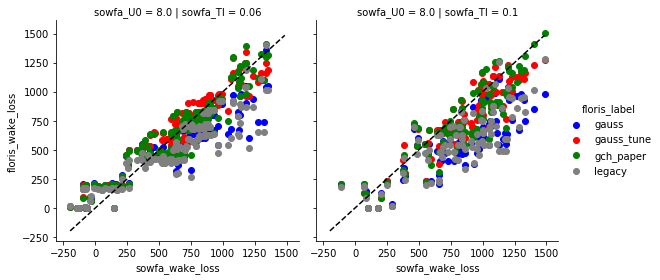

In [11]:
g = sns.FacetGrid(results_df,row='sowfa_U0', col='sowfa_TI',hue='floris_label',size=4,palette=color_dict)
g.map(plt.scatter,'sowfa_wake_loss','floris_wake_loss')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],'k--')
g.add_legend()

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


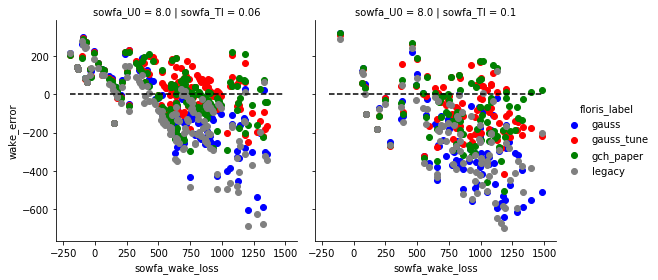

In [12]:
results_df['wake_error'] = results_df.floris_wake_loss - results_df.sowfa_wake_loss
g = sns.FacetGrid(results_df,row='sowfa_U0', col='sowfa_TI',hue='floris_label',size=4,palette=color_dict)
g.map(plt.scatter,'sowfa_wake_loss','wake_error')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [0,0],'k--')
g.add_legend()

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


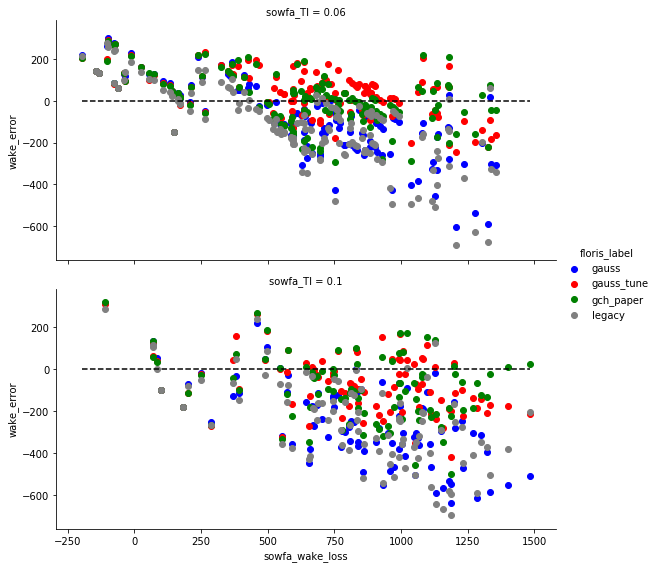

In [13]:
results_df['wake_error'] = results_df.floris_wake_loss - results_df.sowfa_wake_loss
g = sns.FacetGrid(results_df,row='sowfa_TI',hue='floris_label',size=4,aspect=2,palette=color_dict)
g.map(plt.scatter,'sowfa_wake_loss','wake_error')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [0,0],'k--')
g.add_legend()

In [14]:
# Check for an overall bias and rms
results_df[['wake_error','floris_label']].groupby('floris_label').agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])

wake_error                        
                    mean      median    <lambda>
floris_label                                    
gauss        -154.123569 -143.516772  249.692532
gauss_tune     -3.605993   10.720205  129.426688
gch_paper     -34.039725  -28.355948  145.729399
legacy       -172.380745 -162.537992  262.095650

My impression is the better points to the rotor are intrinsically better for multiple wakes, but a rutuning of the TI parameters could help

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


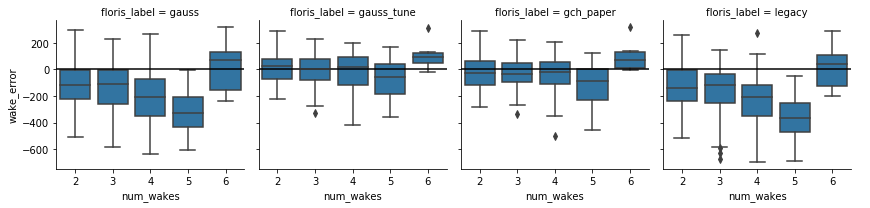

In [16]:
# error_columns = [c for c in df.columns if 'error' in c]
# df_sub = df[error_columns + ['d_spacing']]
# df_sub = pd.melt(df_sub,id_vars='d_spacing')
g = sns.FacetGrid(results_df,col='floris_label',aspect=1)
g.map(sns.boxplot,'num_wakes','wake_error')
for ax in g.axes.flatten():
    ax.axhline(0,color='k')
g.add_legend()